In [1]:
import os

os.system(f'rm -rf {os.path.join(os.environ["CODE"], "plots")}')
os.makedirs(os.path.join(os.environ["CODE"], "plots"), exist_ok=True)


In [2]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

CODE = "/local/home/aarslan/mq"

annotation_json_file_path = f"{CODE}/scripts/08_reproduce_mq_experiments/data/ego4d/ego4d_clip_annotations_v3.json"

with open(annotation_json_file_path, "r") as annotation_json_file:
    annotation_dict = json.load(annotation_json_file)

annotations_data = []

for clip_id, clip_info in annotation_dict.items():
    video_id = clip_info["video_id"]
    clip_duration = clip_info["duration"]
    fps = clip_info["fps"]
    subset = clip_info["subset"]
    if subset in ["train", "val"]:
        for annotation in clip_info["annotations"]:
            annotations_data.append((subset, annotation["label"], video_id, clip_id, clip_duration, fps, annotation["segment"][1] - annotation["segment"][0], annotation["segment"][0], annotation["segment"][1]))
    else:
        annotations_data.append((subset, np.NaN, video_id, clip_id, clip_duration, fps, np.NaN))

annotations_df = pd.DataFrame(data=annotations_data, columns=["subset", "label", "video_id", "clip_id", "clip_duration", "fps", "label_duration", "label_start", "label_end"])


# Number of Clips per Subset Histogram

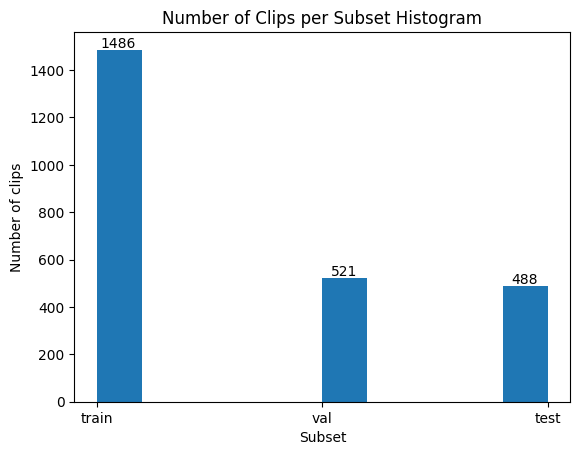

In [3]:
data = annotations_df.drop_duplicates(subset=["clip_id"])["subset"].values
counts, bins, _ = plt.hist(data)

for n, b in zip(counts, bins):
    if n == 0:
        continue
    elif len(str(int(n))) == 4:
        plt.gca().text(b + 0.015, n + 10, str(int(n)))  # +0.1 to center text
    else:
        plt.gca().text(b + 0.04, n + 10, str(int(n)))  # +0.1 to center text

plt.xlabel("Subset")
plt.ylabel("Number of clips")
plt.title("Number of Clips per Subset Histogram")
plt.savefig(os.path.join(os.environ["CODE"], "plots", "number_of_clips_per_subset_histogram.png"), dpi=300)

# plt.title(f"{title} \n Per Gene Pearson Correlation Histogram, Median: {np.round(np.nanmedian(corrs), 2)}, IQR: {np.round(np.nanpercentile(corrs, 75) - np.nanpercentile(corrs, 25), 2)}", fontsize=32)
# plt.vlines(x=np.nanmedian(corrs), ymin=0.0, ymax=np.max(n), color="red", label="Median")


# Number of Annotations per Clip Histogram

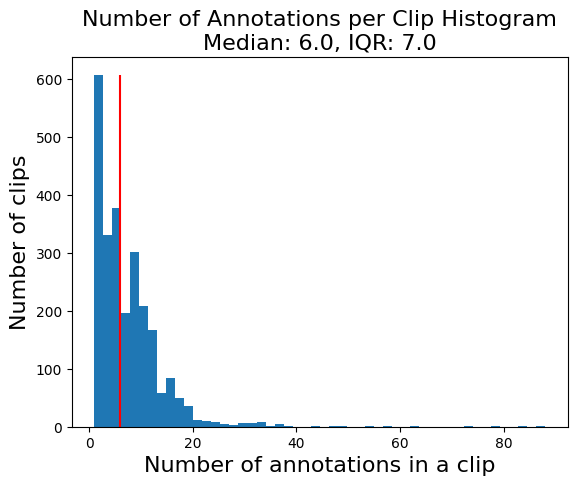

In [4]:
data = annotations_df.groupby("clip_id").count()["subset"]
median = np.median(data)
n, _, _ = plt.hist(data, bins=50)
plt.vlines(x=np.nanmedian(data), ymin=0.0, ymax=np.max(n), color="red", label="Median")
plt.title(f"Number of Annotations per Clip Histogram\nMedian: {np.round(np.nanmedian(data), 2)}, IQR: {np.round(np.nanpercentile(data, 75) - np.nanpercentile(data, 25), 2)}", fontsize=16)

plt.xlabel("Number of annotations in a clip", fontsize=16)
plt.ylabel("Number of clips", fontsize=16)
plt.savefig(os.path.join(os.environ["CODE"], "plots", "number_of_annotations_per_clip_histogram.png"), dpi=300)

# Number of Clips per Video Histogram

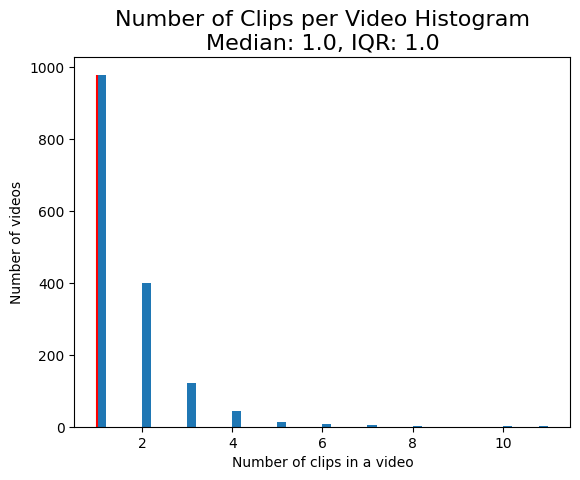

In [5]:
data = annotations_df.groupby(["video_id"]).agg({"clip_id": "nunique"})["clip_id"].values

median = np.median(data)
n, _, _ = plt.hist(data, bins=50)
plt.vlines(x=np.nanmedian(data), ymin=0.0, ymax=np.max(n), color="red", label="Median")
plt.title(f"Number of Clips per Video Histogram\nMedian: {np.round(np.nanmedian(data), 2)}, IQR: {np.round(np.nanpercentile(data, 75) - np.nanpercentile(data, 25), 2)}", fontsize=16)

plt.xlabel("Number of clips in a video")
plt.ylabel("Number of videos")
plt.savefig(os.path.join(os.environ["CODE"], "plots", "number_of_clips_per_video_histogram.png"), dpi=300)


# Clip Duration Histogram

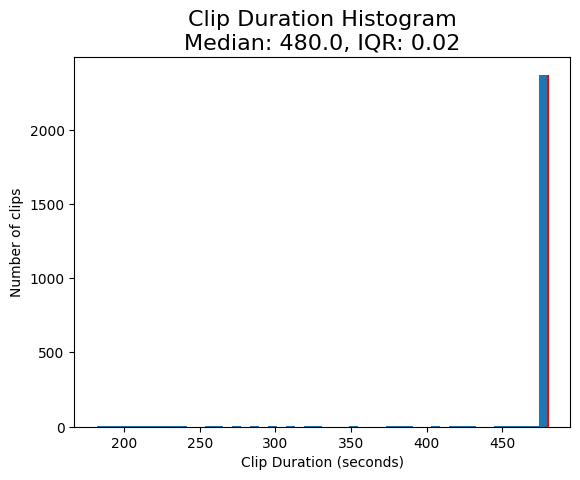

In [6]:
data = annotations_df.drop_duplicates(subset=["clip_id"])["clip_duration"].values

median = np.median(data)
n, _, _ = plt.hist(data, bins=50)
plt.vlines(x=np.nanmedian(data), ymin=0.0, ymax=np.max(n), color="red", label="Median")
plt.title(f"Clip Duration Histogram\nMedian: {np.round(np.nanmedian(data), 2)}, IQR: {np.round(np.nanpercentile(data, 75) - np.nanpercentile(data, 25), 2)}", fontsize=16)

plt.xlabel("Clip Duration (seconds)")
plt.ylabel("Number of clips")
plt.savefig(os.path.join(os.environ["CODE"], "plots", "clip_duration_histogram.png"), dpi=300)


# Annotation Duration Histogram

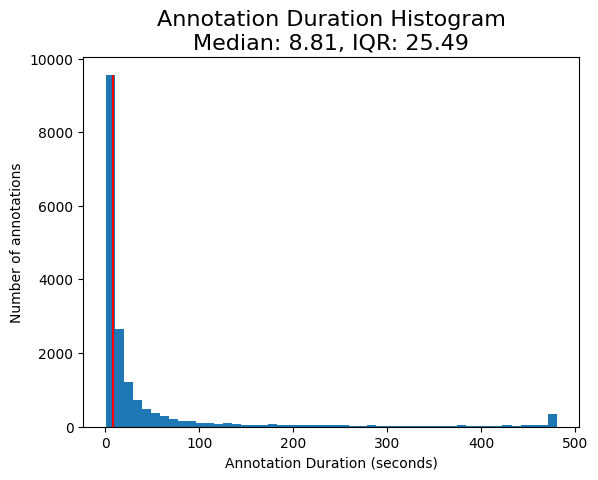

In [7]:
data = annotations_df["label_duration"].values

median = np.median(data)
n, _, _ = plt.hist(data, bins=50)
plt.vlines(x=np.nanmedian(data), ymin=0.0, ymax=np.max(n), color="red", label="Median")
plt.title(f"Annotation Duration Histogram\nMedian: {np.round(np.nanmedian(data), 2)}, IQR: {np.round(np.nanpercentile(data, 75) - np.nanpercentile(data, 25), 2)}", fontsize=16)

plt.xlabel("Annotation Duration (seconds)")
plt.ylabel("Number of annotations")
plt.savefig(os.path.join(os.environ["CODE"], "plots", "annotation_duration.png"))

# Annotation tIoU Histogram

For each annotation, we check the tIoU with other annotations in the same clip. We exclude tIoUs with non-intersecting annotations.

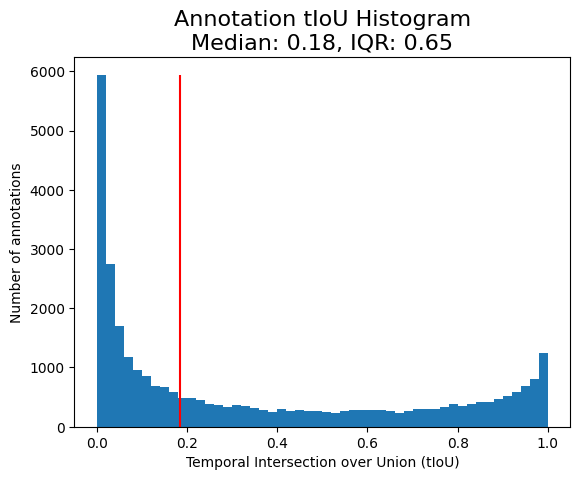

In [8]:
train_val_annotations_df = annotations_df[annotations_df["subset"].apply(lambda x: x in ["train", "val"])]

clip_id_intersection_mapping = {}

tIoUs = []
for current_index, current_row in train_val_annotations_df.iterrows():
    current_clip_id = current_row["clip_id"]
    clip_id_intersection_mapping[current_clip_id] = 0
    current_label_start = current_row["label_start"]
    current_label_end = current_row["label_end"]
    other_rows_with_same_clip_id = train_val_annotations_df[train_val_annotations_df["clip_id"] == current_clip_id]
    for other_index, other_row in other_rows_with_same_clip_id.iterrows():
        if current_index == other_index:
            continue
        other_label_start = other_row["label_start"]
        other_label_end = other_row["label_end"]
        if current_label_start >= other_label_end or other_label_start >= current_label_end: # there is no intersection
            continue
        else:
            clip_id_intersection_mapping[current_clip_id] += 1
            maximum_start = np.maximum(current_label_start, other_label_start)
            minimum_end = np.minimum(current_label_end, other_label_end)
            intersection = minimum_end - maximum_start

            maximum_end = np.maximum(current_label_end, other_label_end)
            minimum_start = np.minimum(current_label_start, other_label_start)
            union = maximum_end - minimum_start

            tIoUs.append(intersection / float(union))
        
            clip_id_intersection_mapping[current_clip_id] += 1

data = tIoUs
median = np.median(data)
n, _, _ = plt.hist(data, bins=50)
plt.vlines(x=np.nanmedian(data), ymin=0.0, ymax=np.max(n), color="red", label="Median")
plt.title(f"Annotation tIoU Histogram\nMedian: {np.round(np.nanmedian(data), 2)}, IQR: {np.round(np.nanpercentile(data, 75) - np.nanpercentile(data, 25), 2)}", fontsize=16)

plt.xlabel("Temporal Intersection over Union (tIoU)")
plt.ylabel("Number of annotations")
plt.savefig(os.path.join(os.environ["CODE"], "plots", "annotation_tiou_histogram.png"), dpi=300)



# Number of Intersections Histogram

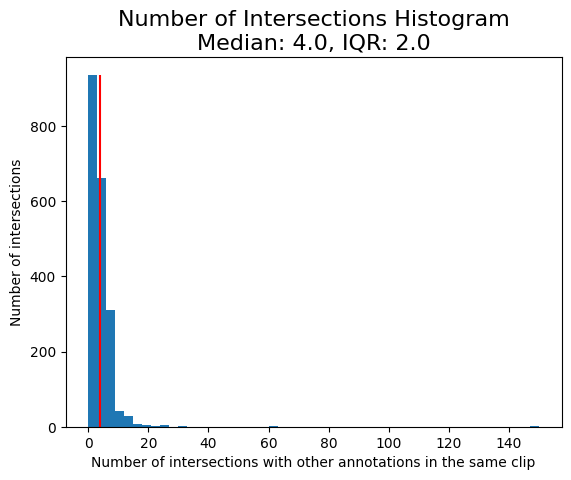

In [9]:
data = list(clip_id_intersection_mapping.values())
median = np.median(data)
n, _, _ = plt.hist(data, bins=50)
plt.vlines(x=np.nanmedian(data), ymin=0.0, ymax=np.max(n), color="red", label="Median")
plt.title(f"Number of Intersections Histogram\nMedian: {np.round(np.nanmedian(data), 2)}, IQR: {np.round(np.nanpercentile(data, 75) - np.nanpercentile(data, 25), 2)}", fontsize=16)

plt.xlabel("Number of intersections with other annotations in the same clip")
plt.ylabel("Number of intersections")
plt.savefig(os.path.join(os.environ["CODE"], "plots", "annotation_number_of_intersections_histogram.png"), dpi=300)


# Label Counts

In [10]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(annotations_df.groupby("label").agg({"subset": "count"}).rename(columns={"subset": "count"}).sort_values(by="count", ascending=False))


,count
label,
converse_/_interact_with_someone,2506
use_phone,1500
browse_through_clothing_items_on_rack_/_shelf_/_hanger,613
read_a_book_/_magazine_/_shopping_list_etc.,582
look_at_clothes_in_the_mirror,343
put_away_(or_take_out)_food_items_in_the_fridge,336
"""cut_/_chop_/_slice_a_vegetable,_fruit,_or_meat""",312
throw_away_trash_/_put_trash_in_trash_can,294
stir_/_mix_food_while_cooking,294
